##1.Understanding region proposals with Selective_search

Region proposal is a technique that helps in identifying islands of where the pixels are similar to one another.

Generating a region proposal comes in handy for object detection where we have to identify the locations of objects present in the image. Furthermore, given a region proposal generates a proposal for the region, it aids in object localization where the task is to identify a bounding box that fits exactly around the object in the image. We learn how region proposals assit in Object localization and detection in a later section Training R-CNN-based custom object detectors, but let's first understand how to generate region proposals from an image.

###1.1 Leveraging SelectiveSearch to generate region proposals

SelectiveSearch is a region proposal algorithm used for object localization where it generates proposals of regions that are likely to be grouped together based on the hierarchical grouping of similar pixels, which, in turn, leverages the color, texture, size and shape compatiblity of content within an image.

Initially, SelectiveSearch over-segments an image by grouping pixels based on the preceding attributes. Next, it iterates through these oveer-segmented groups and groups them based on similarity. At each iteration, it combines smaller regions to form a larger region.


###1.2 Install the required packages

In [14]:
%pip install selectivesearch
%pip install torch_snippets

from torch_snippets import *
from skimage.segmentation import felzenszwalb

###1.3 Fetch and load the required image

In [15]:
!wget -q https://www.dropbox.com/s/lpw10qawsc5ipbn/MyImage.JPG -O MyImage.jpg
img = read('MyImage.jpg', 1)

###1.4 Extract the `felezenszwalb` segements (which are obtained based on the color, texture, size, and shape compatibility of content within an image) from the image.

>Note: In the `felzenswalb` method, scale represents the number of clusters that can be formed within the segments of the image. The higher the value of `scale`, the greater the detail of the original image that is preserved.

In [16]:
segments_fz = felzenszwalb(img, scale=200)

###1.5 Plot the original image and the image with segementation

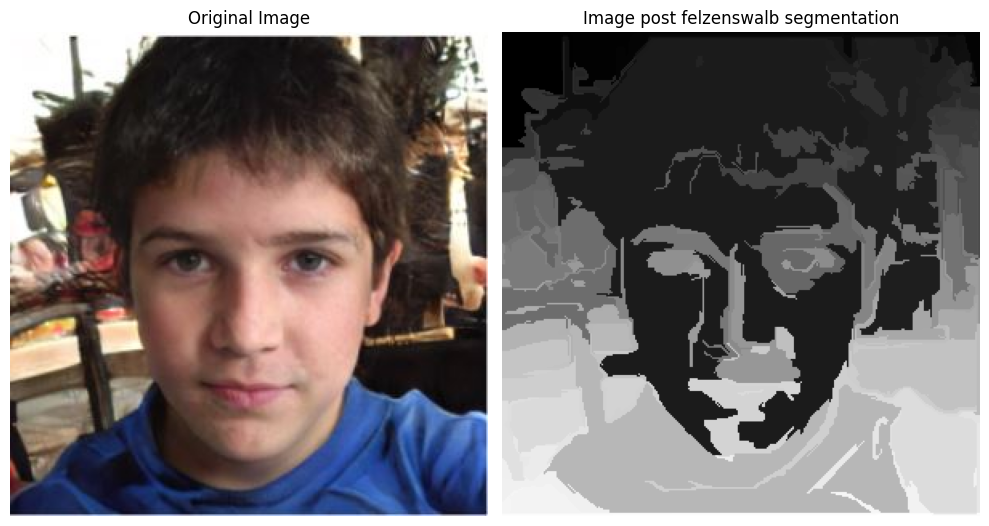

In [17]:
subplots([img, segments_fz], titles=['Original Image', 'Image post felzenswalb segmentation'], sz=10, nc=2)

From the preceding output, note that pixels that belong to the same group have similar pixel values.

>Pixels that have similar values from a region proposal. This now helps in object detection, as we now pass each region proposal to a network and ask it to predict whether the region proposal is a background or an object. Furthermore, if it is an object, it would help us to identify the offset to fetch the tight bounding box corresponding to the object and also the class corresponding to the content within the region proposal.

Now that we understand what SelectiveSearch does, let's implement the `selectivesearch` function to fetch region proposals for the given image.

**Implementing SelectiveSearch to generate region proposals**

We will define the `extract_candidates` functions using `selectivesearch` so that it can be leveraged in the subsequent sections on training R-CNN and Fast R-CNN-based custom object detectors.

###1.6 Define the `extract_candidates` function that fetches the region proposals from an image

In [18]:
def extract_candidates(img):
  'Fetch the candidate regions within the image using the selective_search \
  method available in the selectivesearch package'

  img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)

  'Calculate the image area and initialize a list (candidates) that we will \
  use to store the candidates that pass a defined threshold.'

  img_area = np.prod(img.shape[:2])
  candidates = []

  'Fetch only those candidates (regions) that are over 5% of the total image \
  image area and less than or equal to 100% of the image area and return them.'
  for r in regions:
    if r['rect'] in candidates: continue
    if r['size'] < (0.05 * img_area): continue
    if r['size'] > (1*img_area): continue

    x, y, w, h = r['rect']
    candidates.append(list(r['rect']))

  return candidates

###1.7 Extract candidates and plot them on top of an image

In [20]:
%pip install selectivesearch
%pip install torch_snippets

from torch_snippets import *
import selectivesearch

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


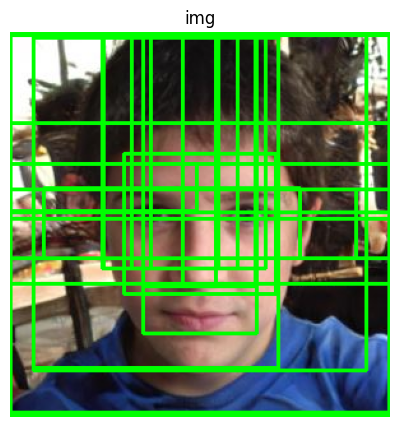

In [21]:
candidates = extract_candidates(img)
show(img, bbs=candidates)

The grids in the preceeding diagram represent the candidate regions (region proposals) coming from the `selective_search` method.

Now that we understand region proposal generation, one question remains unanswered. How do we leverage region proposals for object detection and localization?

A region proposal that has a high intersection with the location (ground truth) of an object in the image of interest is labeled as the one that contains the object, and a region proposal with a low intersection is labeled as background.



##2.Understanding IoU

Let's define a function that takes two bounding boxes as input and returns IoU as the output.

1. Specify the `get_iou` function that takes `boxA` and `boxB` as inputs where `boxA` and `boxB` two different bounding boxes (you can consider `boxA` as the ground truth bounding box and `boxB` as the region proposal):

    We define the `epsilon` parameter to address the rare scenario when the union between the two boxes is 0, resulting in a division by zero error.

    Note that in each of the bounding boxes, there will be four values corresponding to the four corners of the bounding box.

2. Calculate the coordinates of the intersection box

3. Calculate `width` and `height` corresponding to the intersectin area (overlapping region)

4. Calculate the area of overlap (`area_overlap`)

5. Calculate the combined area corresponding to the two bounding boxes.

6. Calculate the IoU and return it.

In [22]:
def get_iou(boxA, boxB, epsilon=1e-5):

  x1 = max(boxA[0], boxB[0])
  y1 = max(boxA[1], boxB[1])
  x2 = min(boxA[2], boxB[2])
  y2 = min(boxA[3], boxB[3])

  width = (x2 - x1)
  height = (y2 - y1)
  if (width < 0) or (height <  0):
    return 0.0

  area_overlap = width * height
  area_a = (boxA[2] - boxA[0]) * (boxA[3]- boxA[1])
  area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

  area_combined = area_a + area_b - area_overlap
  iou = area_overlap / (area_combined + epsilon)

  return iou
